In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt


Loading demo codes modified by He Wang [https://iphysresearch.github.io/]
For original codes, see SDMBIGDAT19 (MATLAB) delivered by Soumya D. Mohanty
[https://github.com/mohanty-sd/SDMBIGDAT19]



In [2]:
# load data
TrainingData = scio.loadmat('TrainingData.mat')
analysisData = scio.loadmat('analysisData.mat')

## Preparing
dataY = analysisData['dataVec'][0] # (2048,)
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
Fs = analysisData['sampFreq'][0,0] # 1024

# Search range of phase coefficients
rmin = [40, 1, 1]
rmax = [100, 50, 15]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
t = np.arange(0, nSamples*dt, dt) # (2048,)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
f = np.arange(0, Nyq+df, df) # Not used...(Herb)
[f, pxx] = welch(TrainingData['trainData'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

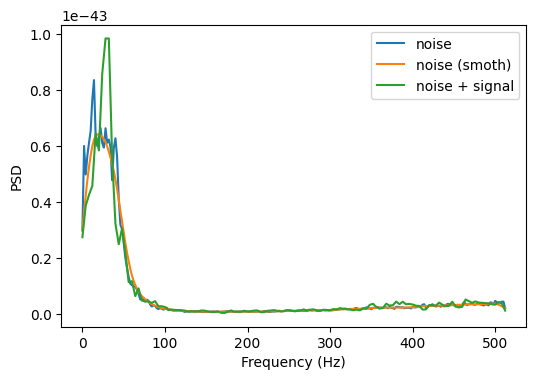

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=100)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smoth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(f,pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('output_psd.png', dpi=100)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    'dataXSq': t**2,
    'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

100%|██████████| 2000/2000 [00:33<00:00, 59.74it/s]


In [7]:
print('Estimated parameters: a1={}; a2={}; a3={}'.format(outResults['bestQcCoefs'][0],
                                                         outResults['bestQcCoefs'][1],
                                                         outResults['bestQcCoefs'][2]))
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters: a1=51.3605915101784; a2=28.832078856931652; a3=10.308191421692223
